## Imports

In [1]:
import datetime
import gc

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import *

In [3]:
cuda_use_gpus(0)

In [4]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


## Config

In [5]:
feature_list_id = 'oofp_siamese_lstm_attention'

In [6]:
RANDOM_SEED = 42

In [7]:
np.random.seed(RANDOM_SEED)

## Read Data

In [8]:
embedding_matrix = load(aux_data_folder + 'embedding_weights_fasttext_filtered_no_stopwords.pickle')

In [9]:
X_train_q1 = load(features_data_folder + 'X_train_nn_fasttext_q1_filtered_no_stopwords.pickle')
X_train_q2 = load(features_data_folder + 'X_train_nn_fasttext_q2_filtered_no_stopwords.pickle')

In [10]:
X_test_q1 = load(features_data_folder + 'X_test_nn_fasttext_q1_filtered_no_stopwords.pickle')
X_test_q2 = load(features_data_folder + 'X_test_nn_fasttext_q2_filtered_no_stopwords.pickle')

In [11]:
y_train = load(features_data_folder + 'y_train.pickle')

In [12]:
EMBEDDING_DIM = embedding_matrix.shape[-1]
VOCAB_LENGTH = embedding_matrix.shape[0]
MAX_SEQUENCE_LENGTH = X_train_q1.shape[-1]

In [13]:
print(EMBEDDING_DIM, VOCAB_LENGTH, MAX_SEQUENCE_LENGTH)

300 101442 30


## Train Models & Compute Out-of-Fold Predictions

In [14]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean((1 - y_true) * K.square(y_pred) +
                   y_true * K.square(K.maximum(margin - y_pred, 0)))

In [15]:
class AttentionWithContext(Layer):
    """
        Attention operation, with a context/query vector, for temporal data.
        Supports Masking.
        Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
        "Hierarchical Attention Networks for Document Classification"
        by using a context vector to assist the attention
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(AttentionWithContext())
        """

    def __init__(self, init='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None, bias_constraint=None,  **kwargs):
        self.supports_masking = True
        self.init = initializers.get(init)
        self.kernel_initializer = initializers.get('glorot_uniform')

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight((input_shape[-1], 1),
                                 initializer=self.kernel_initializer,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.kernel_regularizer,
                                 constraint=self.kernel_constraint)
        self.b = self.add_weight((input_shape[1],),
                                 initializer='zero',
                                 name='{}_b'.format(self.name),
                                 regularizer=self.bias_regularizer,
                                 constraint=self.bias_constraint)

        self.u = self.add_weight((input_shape[1],),
                                 initializer=self.kernel_initializer,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.kernel_regularizer,
                                 constraint=self.kernel_constraint)
        self.built = True

    def compute_mask(self, input, mask):
        return None

    def call(self, x, mask=None):
        # (x, 40, 300) x (300, 1)
        multData =  K.dot(x, self.kernel) # (x, 40, 1)
        multData = K.squeeze(multData, -1) # (x, 40)
        multData = multData + self.b # (x, 40) + (40,)

        multData = K.tanh(multData) # (x, 40)

        multData = multData * self.u # (x, 40) * (40, 1) => (x, 1)
        multData = K.exp(multData) # (X, 1)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            mask = K.cast(mask, K.floatx()) #(x, 40)
            multData = mask*multData #(x, 40) * (x, 40, )

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        multData /= K.cast(K.sum(multData, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        multData = K.expand_dims(multData)
        weighted_input = x * multData
        return K.sum(weighted_input, axis=1)


    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1],)

In [16]:
def create_model(params):
    embedding_layer = Embedding(
        VOCAB_LENGTH,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False,
    )
    lstm_layer = LSTM(
        params['num_lstm'],
        dropout=params['lstm_dropout_rate'],
        recurrent_dropout=params['lstm_dropout_rate'],
        return_sequences=True,
    )
    attention_layer = AttentionWithContext()

    sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_1 = embedding_layer(sequence_1_input)
    x1 = attention_layer(lstm_layer(embedded_sequences_1))

    sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_2 = embedding_layer(sequence_2_input)
    y1 = attention_layer(lstm_layer(embedded_sequences_2))

    merged = concatenate([x1, y1])
    merged = Dropout(params['dense_dropout_rate'])(merged)
    merged = BatchNormalization()(merged)

    merged = Dense(params['num_dense'], activation='relu')(merged)
    merged = Dropout(params['dense_dropout_rate'])(merged)
    merged = BatchNormalization()(merged)

    output = Dense(1, activation='sigmoid')(merged)

    model = Model(
        inputs=[sequence_1_input, sequence_2_input],
        outputs=output
    )

    model.compile(
        loss=contrastive_loss,
        optimizer='nadam',
        metrics=['accuracy']
    )

    return model

In [17]:
model_checkpoint_path = aux_data_folder + 'fold-checkpoint-' + feature_list_id + '.h5'

In [18]:
NUM_FOLDS = 5
NUM_EPOCHS = 200

In [19]:
kfold = StratifiedKFold(
    n_splits=NUM_FOLDS,
    shuffle=True,
    random_state=RANDOM_SEED
)

In [20]:
y_train_oofp = np.zeros_like(y_train, dtype='float64')

In [21]:
y_test_oofp = np.zeros((len(X_test_q1), NUM_FOLDS))

In [22]:
def predict(model, X_q1, X_q2):
    y1 = model.predict(
        [X_q1, X_q2],
        batch_size=1024,
        verbose=1
    ).reshape(-1)
    
    y2 = model.predict(
        [X_q2, X_q1],
        batch_size=1024,
        verbose=1
    ).reshape(-1)
    
    return (y1 + y2) / 2

In [23]:
model_params = {
    'dense_dropout_rate': 0.164,
    'lstm_dropout_rate': 0.324,
    'num_dense': 132,
    'num_lstm': 254,
}

In [24]:
%%time

for fold_num, (ix_train, ix_val) in enumerate(kfold.split(X_train_q1, y_train)):
    X_fold_train_q1 = np.vstack([X_train_q1[ix_train], X_train_q2[ix_train]])
    X_fold_train_q2 = np.vstack([X_train_q2[ix_train], X_train_q1[ix_train]])

    X_fold_val_q1 = np.vstack([X_train_q1[ix_val], X_train_q2[ix_val]])
    X_fold_val_q2 = np.vstack([X_train_q2[ix_val], X_train_q1[ix_val]])

    y_fold_train = np.concatenate([y_train[ix_train], y_train[ix_train]])
    y_fold_val = np.concatenate([y_train[ix_val], y_train[ix_val]])
    
    print()
    print(f'Fitting fold {fold_num + 1} of {kfold.n_splits}')
    print()
    
    model = create_model(model_params)
    model.fit(
        [X_fold_train_q1, X_fold_train_q2], y_fold_train,
        validation_data=([X_fold_val_q1, X_fold_val_q2], y_fold_val),

        batch_size=2048,
        epochs=NUM_EPOCHS,
        verbose=1,
        
        callbacks=[
            EarlyStopping(
                monitor='val_loss',
                min_delta=0.001,
                patience=3,
                verbose=1,
                mode='auto',
            ),
            ModelCheckpoint(
                model_checkpoint_path,
                monitor='val_loss',
                save_best_only=True,
                verbose=2,
            ),
        ],
    )
        
    # Create out-of-fold prediction.
    model.load_weights(model_checkpoint_path)
    
    y_train_oofp[ix_val] = predict(model, X_train_q1[ix_val], X_train_q2[ix_val])
    y_test_oofp[:, fold_num] = predict(model, X_test_q1, X_test_q2)
    
    # Clear GPU memory.
    K.clear_session()
    del X_fold_train_q1
    del X_fold_train_q2
    del X_fold_val_q1
    del X_fold_val_q2
    del model
    gc.collect()


Fitting fold 1 of 5

Train on 646862 samples, validate on 161718 samples
Epoch 1/200
646862/646862 [==============================] - 76s - loss: 0.1865 - acc: 0.7148 - val_loss: 0.2041 - val_acc: 0.6519
Epoch 2/200
646862/646862 [==============================] - 77s - loss: 0.1572 - acc: 0.7660 - val_loss: 0.1508 - val_acc: 0.7849
Epoch 3/200
646862/646862 [==============================] - 74s - loss: 0.1437 - acc: 0.7890 - val_loss: 0.1391 - val_acc: 0.7968
Epoch 4/200
646862/646862 [==============================] - 74s - loss: 0.1347 - acc: 0.8039 - val_loss: 0.1282 - val_acc: 0.8134
Epoch 5/200
646862/646862 [==============================] - 71s - loss: 0.1276 - acc: 0.8162 - val_loss: 0.1242 - val_acc: 0.8212
Epoch 6/200
646862/646862 [==============================] - 71s - loss: 0.1218 - acc: 0.8258 - val_loss: 0.1198 - val_acc: 0.8285
Epoch 7/200
646862/646862 [==============================] - 71s - loss: 0.1175 - acc: 0.8328 - val_loss: 0.1194 - val_acc: 0.8302
Epoch 8/2

646862/646862 [==============================] - 77s - loss: 0.1220 - acc: 0.8253 - val_loss: 0.1208 - val_acc: 0.8269
Epoch 7/200
646862/646862 [==============================] - 75s - loss: 0.1175 - acc: 0.8330 - val_loss: 0.1198 - val_acc: 0.8275
Epoch 8/200
646862/646862 [==============================] - 74s - loss: 0.1136 - acc: 0.8392 - val_loss: 0.1205 - val_acc: 0.8273
Epoch 9/200
646862/646862 [==============================] - 74s - loss: 0.1101 - acc: 0.8450 - val_loss: 0.1149 - val_acc: 0.8365
Epoch 10/200
646862/646862 [==============================] - 78s - loss: 0.1073 - acc: 0.8495 - val_loss: 0.1179 - val_acc: 0.8314
Epoch 11/200
646862/646862 [==============================] - 77s - loss: 0.1044 - acc: 0.8540 - val_loss: 0.1147 - val_acc: 0.8365
Epoch 12/200
646862/646862 [==============================] - 77s - loss: 0.1024 - acc: 0.8572 - val_loss: 0.1163 - val_acc: 0.8343
Epoch 13/200
646862/646862 [==============================] - 79s - loss: 0.1003 - acc: 0.86

646864/646864 [==============================] - 75s - loss: 0.1095 - acc: 0.8455 - val_loss: 0.1209 - val_acc: 0.8272
Epoch 10/200
646864/646864 [==============================] - 76s - loss: 0.1066 - acc: 0.8504 - val_loss: 0.1172 - val_acc: 0.8321
Epoch 11/200
646864/646864 [==============================] - 78s - loss: 0.1041 - acc: 0.8541 - val_loss: 0.1141 - val_acc: 0.8384
Epoch 12/200
646864/646864 [==============================] - 79s - loss: 0.1017 - acc: 0.8582 - val_loss: 0.1169 - val_acc: 0.8346
Epoch 13/200
646864/646864 [==============================] - 77s - loss: 0.0998 - acc: 0.8611 - val_loss: 0.1125 - val_acc: 0.8413
Epoch 14/200
646864/646864 [==============================] - 77s - loss: 0.0978 - acc: 0.8642 - val_loss: 0.1169 - val_acc: 0.8352
Epoch 15/200
646864/646864 [==============================] - 77s - loss: 0.0961 - acc: 0.8666 - val_loss: 0.1137 - val_acc: 0.8409
Epoch 16/200
646864/646864 [==============================] - 79s - loss: 0.0950 - acc: 0

646866/646866 [==============================] - 78s - loss: 0.0968 - acc: 0.8655 - val_loss: 0.1120 - val_acc: 0.8422
Epoch 16/200
646866/646866 [==============================] - 78s - loss: 0.0956 - acc: 0.8673 - val_loss: 0.1130 - val_acc: 0.8427
Epoch 17/200
646866/646866 [==============================] - 79s - loss: 0.0941 - acc: 0.8697 - val_loss: 0.1139 - val_acc: 0.8400
Epoch 18/200
646866/646866 [==============================] - 81s - loss: 0.0929 - acc: 0.8712 - val_loss: 0.1118 - val_acc: 0.8440
Epoch 19/200
646866/646866 [==============================] - 81s - loss: 0.0920 - acc: 0.8733 - val_loss: 0.1127 - val_acc: 0.8429
Epoch 00018: early stopping
2345796/2345796 [==============================] - 121s   

Fitting fold 5 of 5

Train on 646866 samples, validate on 161714 samples
Epoch 1/200
646866/646866 [==============================] - 83s - loss: 0.1847 - acc: 0.7167 - val_loss: 0.1997 - val_acc: 0.6955
Epoch 2/200
646866/646866 [==============================] - 

In [25]:
cv_score = log_loss(y_train, y_train_oofp)
print('CV score:', cv_score)

CV score: 0.357949355293


## Save feature names

In [26]:
feature_names = [
    'oofp_siamese_lstm_attention',
]

In [27]:
save_lines(feature_names, features_data_folder + f'X_train_{feature_list_id}.names')

## Save Train features

In [28]:
y_train_oofp = y_train_oofp.reshape((-1, 1))

In [29]:
save(y_train_oofp, features_data_folder + f'X_train_{feature_list_id}.pickle')

## Save Test features

In [30]:
y_test_oofp_mean = np.mean(y_test_oofp, axis=1).reshape((-1, 1))

In [31]:
save(y_test_oofp_mean, features_data_folder + f'X_test_{feature_list_id}.pickle')

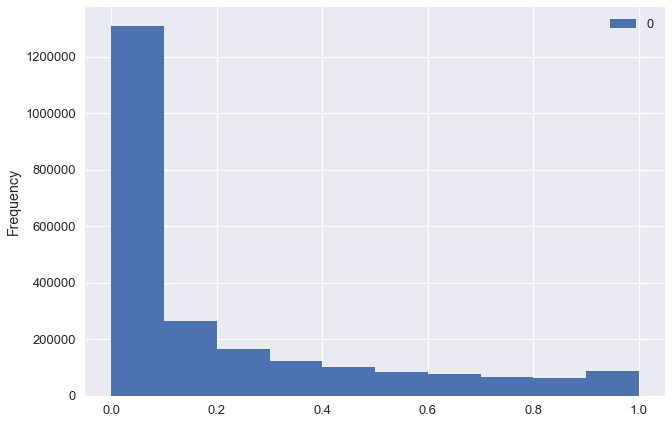

In [32]:
pd.DataFrame(y_test_oofp_mean).plot.hist()